### Plotting COVID-19 by State, and an HMM Fit

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm
import warnings

import plotly.express as px

The following is a function that allows the user to plot COVID-related metrics from mid-February to the last week of October, for any of the 50 states. This function also serves as the backend for my Streamlit App: 'covid-by-state.' 

The parameters decided by the user are as follows:
- **state:** (String) The user enters one of the 50 states to be observed over the entire time period of the dataset.

- **metric:** (String) The user inputs their desired metric to be displayed over this period, either cases or deaths.

- **date_of_interest**: (DateTime) One or more specific dates on which there may have been superspreader events in the user's inputted state. This plots a vertical line onto the plot at that date index.

- **fig_type:** (String) The user indicates in which format they want to see the metric data. The options are:
    - Cumulative Daily Change: The graph will show the total cases/deaths for each day in the inputted state.
    - Absolute Daily Change: The graph will show only NEW cases/deaths reported for each day.
    - Normalized Daily Change: Same as Absolute Daily Change, but normalized to a maximum value of 1.0. This is done to accommodate an HMM fit and plot on top of the graph.
    
- **hmm_plot:** (Boolean) The user indicates whether they would like a Hidden Markov Model to be fitted and plotted to the graph. This allows the user to observe notable changes in the shape of the progression curve for the given metric, and also observe potential connections between these regimes and superspreader events. Note that this will only fit and plot to the graph if fig_type = Normalized Daily Change.

- **n_components:** (Integer) The hyperparameter for the HMM indicating the number of regimes to split the curve

In [15]:
warnings.filterwarnings('ignore')

C:\Users\User\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [16]:
def plot_hmm_px(state, metric='cases', dates_of_interest=None, hmm_plot=False, n_components=3, fig_type = 'Normalized Daily Change'):
    '''
    You can switch metric to 'deaths' if you want.
    
    '''
    df = pd.read_csv('../../covid-19-data/us-states.csv')
    state_df = df[df['state'] == state]
    state_df.drop(columns='state', inplace=True)
    state_df['date']= pd.to_datetime(state_df['date'])
    state_df.set_index('date', inplace=True)
    state_diff = state_df.diff()
    state_diff.dropna(inplace=True)
    
    Xcuml = state_df[[metric]]
    X = state_diff[[metric]]
    
    fig = px.line(X/(X.max() - X.min()),title=f'{state.title()} Daily COVID-19 {metric.capitalize()} Change')
    fig_abs_change = px.line(X,title=f'{state.title()} Daily COVID-19 {metric.capitalize()} Change')
    fig_cuml_change = px.line(Xcuml,title=f'{state.title()} Daily COVID-19 {metric.capitalize()} Change')
    
    if dates_of_interest:
        i=0
        j=0
        k=0
        for date in dates_of_interest:
            fig.add_scatter(x=(date,date),y=(0,1.1),line={'color': f'rgb({i},{j},{k})','width': 2,}, name='Superspreader')
    
    if hmm_plot:  
        model = hmm.GaussianHMM(n_components=n_components)
        model.fit(X)
        preds = model.predict(X) / 2
        fig.add_scatter(x=X.index, y=preds, name='Regime')
    
    if fig_type == 'Normalized Daily Change':
        return fig
    elif fig_type == 'Absolute Daily Change':
        return fig_abs_change
    elif fig_type == 'Cumulative Daily Change':  
        return fig_cuml_change

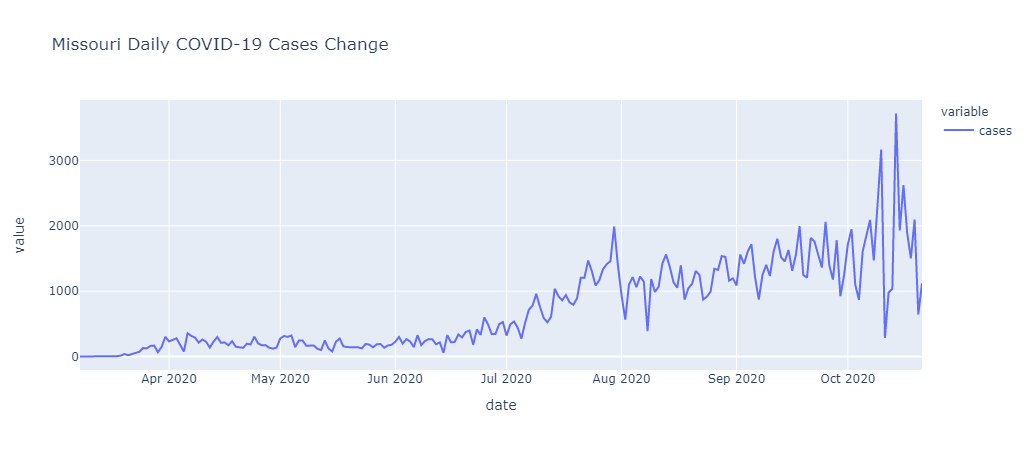

In [17]:
plot_hmm_px(
    state='Missouri', 
    metric='cases', 
    dates_of_interest=['2020-09-10','2020-09-20'], 
    hmm_plot=True,
    n_components=3,
    fig_type = 'Absolute Daily Change'
)